# **Fake news classifier**

In [100]:
# First we import the required libraries

import tensorflow as tf
import threading
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
from joblib import dump
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [101]:
# Connect to Google Drive 
# Upload the dataset to your Google drive so it can be loaded here

#from google.colab import drive
#drive.mount('/content/gdrive')

In [102]:
# Retrieve the data

df = pd.read_excel('../../../train.xlsx')
df = df.fillna(' ')
df.loc[df['Category'] == 'True','Category']=float(0.0)
df.loc[df['Category'] == 'Fake','Category']=float(1.0)

df

#df = pd.read_csv('/content/gdrive/My Drive/FakeNewsData.csv')
#df = df.fillna(' ')
df.count()

Id          676
Category    676
Topic       676
Source      676
Headline    676
Text        676
Link        676
dtype: int64

In [103]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['Text'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

25342


In [104]:
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Category'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Category'].values[split_n:]
#train_labels = np.asarray(train_labels).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')
train_data = np.asarray(train_data).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')
print(test_data)
print(test_labels)
print(train_data)
print(train_labels)


[[8489  471    2 ...    0    0    0]
 [   2  773    1 ...    0    0    0]
 [4724 3660    7 ...    0    0    0]
 ...
 [5367 4453  144 ...    0    0    0]
 [ 889  425 1927 ...    0    0    0]
 [ 496    1 1499 ...    0    0    0]]
[1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.]
[[1.225e+03 2.786e+03 2.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.000e+00 9.600e+02 5.376e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [4.541e+03 3.486e+03 8.653e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [1.914e+03 4.500e+02 5.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.528e+03 1.770e+02 2.790e+02 ... 2.560e+02 1.000e+00 2.000e+00]
 [3.390e+02 2.460e+0

In [105]:
# Import tensor representations for words

#!curl http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip glove*.zip
embeddings_index = {};
with open('./glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        #coefs = np.asarray(values[1:], dtype='float32');
        #coefs =  np.asarray(values[1:]).astype('float32')
        coefs =  values[1:];
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

100


In [106]:
# Build the architecture of the model
     
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [107]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
history = model.fit(train_data, train_labels, epochs=5, batch_size=100, validation_data=[test_data, test_labels])


print("Training Complete")



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2534300   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

TypeError: can't pickle _thread._local objects

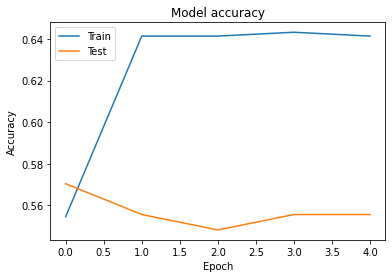

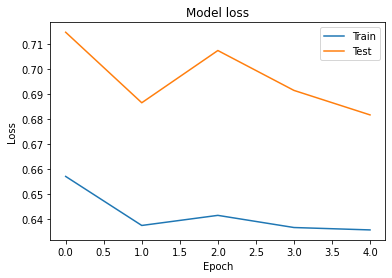

In [108]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()